# OLD

DATA PROCESSING

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import cv2
import json
import pybullet as p

NUM_VIEWS_PER_SCENE = 7

BACKGROUND_LABEL = 0
TABLE_LABEL = 1
OBJECTS_LABEL = 2

In [2]:
# https://github.com/chrisdxie/uois/blob/master/src/util/utilities.py

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_color_mask(object_index, nc=None):
    """ Colors each index differently. Useful for visualizing semantic masks

        @param object_index: a [H x W] numpy array of ints from {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """
    object_index = object_index.astype(int)

    if nc is None:
        NUM_COLORS = object_index.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    color_mask = np.zeros(object_index.shape + (3,)).astype(np.uint8)
    for i in np.unique(object_index):
        if i == 0 or i == -1:
            continue
        color_mask[object_index == i, :] = np.array(colors[i][:3]) * 255
        
    return color_mask


def build_matrix_of_indices(height, width):
    """ Builds a [height, width, 2] numpy array containing coordinates.

        @return: 3d array B s.t. B[..., 0] contains y-coordinates, B[..., 1] contains x-coordinates
    """
    return np.indices((height, width), dtype=np.float32).transpose(1,2,0)


def concatenate_spatial_coordinates(feature_map):
    """ Adds x,y coordinates as channels to feature map

        @param feature_map: a [T x C x H x W] torch tensor
    """
    T, C, H, W = feature_map.shape

    # build matrix of indices. then replicated it T times
    MoI = build_matrix_of_indices(H, W) # Shape: [H, W, 2]
    MoI = np.tile(MoI, (T, 1, 1, 1)) # Shape: [T, H, W, 2]
    MoI[..., 0] = MoI[..., 0] / (H-1) * 2 - 1 # in [-1, 1]
    MoI[..., 1] = MoI[..., 1] / (W-1) * 2 - 1
    MoI = torch.from_numpy(MoI).permute(0,3,1,2).to(feature_map.device) # Shape: [T, 2, H, W]

    # Concatenate on the channels dimension
    feature_map = torch.cat([feature_map, MoI], dim=1)

    return feature_map


def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    from matplotlib.patches import Polygon

    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im
    

### The two functions below were adatped from the DAVIS public dataset ###

def imread_indexed(filename):
    """ Load segmentation image (with palette) given filename."""
    im = Image.open(filename)
    annotation = np.array(im)
    return annotation


def imwrite_indexed(filename,array):
    """ Save indexed png with palette."""

    palette_abspath = '/home/chrisxie/projects/random_stuff/palette.txt' # hard-coded filepath
    color_palette = np.loadtxt(palette_abspath, dtype=np.uint8).reshape(-1,3)

    if np.atleast_3d(array).shape[2] != 1:
        raise Exception("Saving indexed PNGs requires 2D array.")

    im = Image.fromarray(array)
    im.putpalette(color_palette.ravel())
    im.save(filename, format='PNG')


def mask_to_tight_box_numpy(mask):
    """ Return bbox given mask

        @param mask: a [H x W] numpy array
    """
    a = np.transpose(np.nonzero(mask))
    bbox = np.min(a[:, 1]), np.min(a[:, 0]), np.max(a[:, 1]), np.max(a[:, 0])
    return bbox  # x_min, y_min, x_max, y_max


def mask_to_tight_box_pytorch(mask):
    """ Return bbox given mask

        @param mask: a [H x W] torch tensor
    """
    a = torch.nonzero(mask)
    bbox = torch.min(a[:, 1]), torch.min(a[:, 0]), torch.max(a[:, 1]), torch.max(a[:, 0])
    return bbox  # x_min, y_min, x_max, y_max


def mask_to_tight_box(mask):
    if type(mask) == torch.Tensor:
        return mask_to_tight_box_pytorch(mask)
    elif type(mask) == np.ndarray:
        return mask_to_tight_box_numpy(mask)
    else:
        raise Exception(f"Data type {type(mask)} not understood for mask_to_tight_box...")


def compute_xyz(depth_img, camera_params):
    """ Compute ordered point cloud from depth image and camera parameters.
        Assumes camera uses left-handed coordinate system, with 
            x-axis pointing right
            y-axis pointing up
            z-axis pointing "forward"

        @param depth_img: a [H x W] numpy array of depth values in meters
        @param camera_params: a dictionary with parameters of the camera used 

        @return: a [H x W x 3] numpy array
    """

    # Compute focal length from camera parameters
    if 'fx' in camera_params and 'fy' in camera_params:
        fx = camera_params['fx']
        fy = camera_params['fy']
    else: # simulated data
        aspect_ratio = camera_params['img_width'] / camera_params['img_height']
        e = 1 / (np.tan(np.radians(camera_params['fov']/2.)))
        t = camera_params['near'] / e; b = -t
        r = t * aspect_ratio; l = -r
        alpha = camera_params['img_width'] / (r-l) # pixels per meter
        focal_length = camera_params['near'] * alpha # focal length of virtual camera (frustum camera)
        fx = focal_length; fy = focal_length

    if 'x_offset' in camera_params and 'y_offset' in camera_params:
        x_offset = camera_params['x_offset']
        y_offset = camera_params['y_offset']
    else: # simulated data
        x_offset = camera_params['img_width']/2
        y_offset = camera_params['img_height']/2

    indices = build_matrix_of_indices(camera_params['img_height'], camera_params['img_width'])
    indices[..., 0] = np.flipud(indices[..., 0]) # pixel indices start at top-left corner. for these equations, it starts at bottom-left
    z_e = depth_img
    x_e = (indices[..., 1] - x_offset) * z_e / fx
    y_e = (indices[..., 0] - y_offset) * z_e / fy
    xyz_img = np.stack([x_e, y_e, z_e], axis=-1) # Shape: [H x W x 3]

    return xyz_img


def seg2bmap(seg, return_contour=False):
    """ From a segmentation, compute a binary boundary map with 1 pixel wide
        boundaries. This boundary lives on the mask, i.e. it's a subset of the mask.

        @param seg: a [H x W] numpy array of values in {0,1}

        @return: a [H x W] numpy array of values in {0,1}
                 a [2 x num_boundary_pixels] numpy array. [0,:] is y-indices, [1,:] is x-indices
    """
    seg = seg.astype(np.uint8)
    contours, hierarchy = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    temp = np.zeros_like(seg)
    bmap = cv2.drawContours(temp, contours, -1, 1, 1)

    if return_contour: # Return the SINGLE largest contour
        contour_sizes = [len(c) for c in contours]
        ind = np.argmax(contour_sizes)
        contour = np.ascontiguousarray(np.fliplr(contours[ind][:,0,:]).T) # Shape: [2 x num_boundary_pixels]
        return bmap, contour
    else:
        return bmap
    

def largest_connected_component(mask, connectivity=4):
    """ Run connected components algorithm and return mask of largest one

        @param mask: a [H x W] numpy array 

        @return: a [H x W] numpy array of same type as input
    """

    # Run connected components algorithm
    num_components, components = cv2.connectedComponents(mask.astype(np.uint8), connectivity=connectivity)

    # Find largest connected component via set distance
    largest_component_num = -1
    largest_component_size = -1 
    for j in range(1, num_components):
        component_size = np.count_nonzero(components == j)
        if component_size > largest_component_size:
            largest_component_num = j
            largest_component_size = component_size

    return (components == largest_component_num).astype(mask.dtype)


def torch_to_numpy(torch_tensor, is_standardized_image = False):
    """ Converts torch tensor (NCHW) to numpy tensor (NHWC) for plotting
    
        If it's an rgb image, it puts it back in [0,255] range (and undoes ImageNet standardization)
    """
    np_tensor = torch_tensor.cpu().clone().detach().numpy()
    if np_tensor.ndim == 4: # NCHW
        np_tensor = np_tensor.transpose(0,2,3,1)
    if is_standardized_image:
        _mean=[0.485, 0.456, 0.406]; _std=[0.229, 0.224, 0.225]
        for i in range(3):
            np_tensor[...,i] *= _std[i]
            np_tensor[...,i] += _mean[i]
        np_tensor *= 255
            
    return np_tensor


def subplotter(images, titles=None, fig_num=1, plot_width=5):
    """ Function for plotting side-by-side images."""

    num_images = len(images)
    fig = plt.figure(fig_num, figsize=(num_images*plot_width, plot_width))

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        if titles:
            plt.title(titles[i])

In [3]:
# https://github.com/chrisdxie/uois/blob/master/src/data_augmentation.py

import torch
import random
import numpy as np
import cv2

# My Libraries
# from .util import utilities as util_


##### Useful Utilities #####

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """

    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor

def translate(img, tx, ty, interpolation=cv2.INTER_LINEAR):
    """ Translate img by tx, ty

        @param img: a [H x W x C] image (could be an RGB image, flow image, or label image)
    """
    H, W = img.shape[:2]
    M = np.array([[1,0,tx],
                  [0,1,ty]], dtype=np.float32)
    return cv2.warpAffine(img, M, (W, H), flags=interpolation)

def rotate(img, angle, center=None, interpolation=cv2.INTER_LINEAR):
    """ Rotate img <angle> degrees counter clockwise w.r.t. center of image

        @param img: a [H x W x C] image (could be an RGB image, flow image, or label image)
    """
    H, W = img.shape[:2]
    if center is None:
        center = (W//2, H//2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    return cv2.warpAffine(img, M, (W, H), flags=interpolation)




##### Depth augmentations #####

def add_noise_to_depth(depth_img, noise_params):
    """ Add noise to depth image. 
        This is adapted from the DexNet 2.0 code.
        Their code: https://github.com/BerkeleyAutomation/gqcnn/blob/75040b552f6f7fb264c27d427b404756729b5e88/gqcnn/sgd_optimizer.py

        @param depth_img: a [H x W] set of depth z values
    """
    depth_img = depth_img.copy()

    # Multiplicative noise: Gamma random variable
    multiplicative_noise = np.random.gamma(noise_params['gamma_shape'], noise_params['gamma_scale'])
    depth_img = multiplicative_noise * depth_img

    return depth_img

def add_noise_to_xyz(xyz_img, depth_img, noise_params):
    """ Add (approximate) Gaussian Process noise to ordered point cloud

        @param xyz_img: a [H x W x 3] ordered point cloud
    """
    xyz_img = xyz_img.copy()

    H, W, C = xyz_img.shape

    # Additive noise: Gaussian process, approximated by zero-mean anisotropic Gaussian random variable,
    #                 which is rescaled with bicubic interpolation.
    gp_rescale_factor = np.random.randint(noise_params['gp_rescale_factor_range'][0],
                                          noise_params['gp_rescale_factor_range'][1])
    gp_scale = np.random.uniform(noise_params['gaussian_scale_range'][0],
                                 noise_params['gaussian_scale_range'][1])

    small_H, small_W = (np.array([H, W]) / gp_rescale_factor).astype(int)
    additive_noise = np.random.normal(loc=0.0, scale=gp_scale, size=(small_H, small_W, C))
    additive_noise = cv2.resize(additive_noise, (W, H), interpolation=cv2.INTER_CUBIC)
    xyz_img[depth_img > 0, :] += additive_noise[depth_img > 0, :]

    return xyz_img

def dropout_random_ellipses(depth_img, noise_params):
    """ Randomly drop a few ellipses in the image for robustness.
        This is adapted from the DexNet 2.0 code.
        Their code: https://github.com/BerkeleyAutomation/gqcnn/blob/75040b552f6f7fb264c27d427b404756729b5e88/gqcnn/sgd_optimizer.py

        @param depth_img: a [H x W] set of depth z values
    """
    depth_img = depth_img.copy()

    # Sample number of ellipses to dropout
    num_ellipses_to_dropout = np.random.poisson(noise_params['ellipse_dropout_mean'])

    # Sample ellipse centers
    nonzero_pixel_indices = np.array(np.where(depth_img > 0)).T # Shape: [#nonzero_pixels x 2]
    dropout_centers_indices = np.random.choice(nonzero_pixel_indices.shape[0], size=num_ellipses_to_dropout)
    dropout_centers = nonzero_pixel_indices[dropout_centers_indices, :] # Shape: [num_ellipses_to_dropout x 2]

    # Sample ellipse radii and angles
    x_radii = np.random.gamma(noise_params['ellipse_gamma_shape'], noise_params['ellipse_gamma_scale'], size=num_ellipses_to_dropout)
    y_radii = np.random.gamma(noise_params['ellipse_gamma_shape'], noise_params['ellipse_gamma_scale'], size=num_ellipses_to_dropout)
    angles = np.random.randint(0, 360, size=num_ellipses_to_dropout)

    # Dropout ellipses
    for i in range(num_ellipses_to_dropout):
        center = dropout_centers[i, :]
        x_radius = np.round(x_radii[i]).astype(int)
        y_radius = np.round(y_radii[i]).astype(int)
        angle = angles[i]

        # dropout the ellipse
        mask = np.zeros_like(depth_img)
        mask = cv2.ellipse(mask, tuple(center[::-1]), (x_radius, y_radius), angle=angle, startAngle=0, endAngle=360, color=1, thickness=-1)
        depth_img[mask == 1] = 0

    return depth_img




##### RGB Augmentations #####

def standardize_image(image):
    """ Convert a numpy.ndarray [H x W x 3] of images to [0,1] range, and then standardizes

        @return: a [H x W x 3] numpy array of np.float32
    """
    image_standardized = np.zeros_like(image).astype(np.float32)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(3):
        image_standardized[...,i] = (image[...,i]/255. - mean[i]) / std[i]

    return image_standardized

def unstandardize_image(image):
    """ Convert a numpy.ndarray [H x W x 3] standardized image back to RGB (type np.uint8)
        Inverse of standardize_image()

        @return: a [H x W x 3] numpy array of type np.uint8
    """

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    orig_img = (image * std[None,None,:] + mean[None,None,:]) * 255.
    return orig_img.round().astype(np.uint8)

def random_color_warp(image, d_h=None, d_s=None, d_l=None):
    """ Given an RGB image [H x W x 3], add random hue, saturation and luminosity to the image

        Code adapted from: https://github.com/yuxng/PoseCNN/blob/master/lib/utils/blob.py
    """
    H, W, _ = image.shape

    image_color_warped = np.zeros_like(image)

    # Set random hue, luminosity and saturation which ranges from -0.1 to 0.1
    if d_h is None:
        d_h = (random.random() - 0.5) * 0.2 * 256
    if d_l is None:
        d_l = (random.random() - 0.5) * 0.2 * 256
    if d_s is None:
        d_s = (random.random() - 0.5) * 0.2 * 256

    # Convert the RGB to HLS
    hls = cv2.cvtColor(image.round().astype(np.uint8), cv2.COLOR_RGB2HLS)
    h, l, s = cv2.split(hls)

    # Add the values to the image H, L, S
    new_h = (np.round((h + d_h)) % 256).astype(np.uint8)
    new_l = np.round(np.clip(l + d_l, 0, 255)).astype(np.uint8)
    new_s = np.round(np.clip(s + d_s, 0, 255)).astype(np.uint8)

    # Convert the HLS to RGB
    new_hls = cv2.merge((new_h, new_l, new_s)).astype(np.uint8)
    new_im = cv2.cvtColor(new_hls, cv2.COLOR_HLS2RGB)

    image_color_warped = new_im.astype(np.float32)

    return image_color_warped

def random_horizontal_flip(image, label):
    """Randomly horizontally flip the image/label w.p. 0.5

        @param image: a [H x W x 3] numpy array
        @param label: a [H x W] numpy array
    """

    if random.random() > 0.5:
        image = np.fliplr(image).copy()
        label = np.fliplr(label).copy()

    return image, label


##### Label transformations #####

def random_morphological_transform(label, noise_params):
    """ Randomly erode/dilate the label

        @param label: a [H x W] numpy array of {0, 1}
    """

    num_tries = 0
    valid_transform = False
    while not valid_transform:

        if num_tries >= noise_params['max_augmentation_tries']:
            print('Morph: Exhausted number of augmentation tries...')
            return label

        # Sample whether we do erosion or dilation, and kernel size for that
        x_min, y_min, x_max, y_max = mask_to_tight_box(label)
        sidelength = np.mean([x_max - x_min, y_max - y_min])

        morphology_kernel_size = 0; num_ksize_tries = 0;
        while morphology_kernel_size == 0:
            if num_ksize_tries >= 50: # 50 tries for this
                print(f'Morph: Exhausted number of augmentation tries... Sidelength: {sidelength}')
                return label

            dilation_percentage = np.random.beta(noise_params['label_dilation_alpha'], 
                                                 noise_params['label_dilation_beta'])
            morphology_kernel_size = int(round(sidelength * dilation_percentage))

            num_ksize_tries += 1

        iterations = np.random.randint(1, noise_params['morphology_max_iters']+1)

        # Erode/dilate the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morphology_kernel_size, morphology_kernel_size))
        if np.random.rand() < 0.5:
            morphed_label = cv2.erode(label, kernel, iterations=iterations)
        else:
            morphed_label = cv2.dilate(label, kernel, iterations=iterations)

        # Make sure there the mass is reasonable
        if (np.count_nonzero(morphed_label) / morphed_label.size > 0.001) and \
           (np.count_nonzero(morphed_label) / morphed_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return morphed_label

def random_ellipses(label, noise_params):
    """ Randomly add/drop a few ellipses in the mask
        This is adapted from the DexNet 2.0 code.
        Their code: https://github.com/BerkeleyAutomation/gqcnn/blob/75040b552f6f7fb264c27d427b404756729b5e88/gqcnn/sgd_optimizer.py

        @param label: a [H x W] numpy array of {0, 1}
    """
    H, W = label.shape

    num_tries = 0
    valid_transform = False
    while not valid_transform:

        if num_tries >= noise_params['max_augmentation_tries']:
            print('Ellipse: Exhausted number of augmentation tries...')
            return label

        new_label = label.copy()

        # Sample number of ellipses to include/dropout
        num_ellipses = np.random.poisson(noise_params['num_ellipses_mean'])

        # Sample ellipse centers by sampling from Gaussian at object center
        pixel_indices = build_matrix_of_indices(H, W)
        h_idx, w_idx = np.where(new_label)
        mu = np.mean(pixel_indices[h_idx, w_idx, :], axis=0) # Shape: [2]. y_center, x_center
        sigma = 2*np.cov(pixel_indices[h_idx, w_idx, :].T) # Shape: [2 x 2]
        if np.any(np.isnan(mu)) or np.any(np.isnan(sigma)):
            print(mu, sigma, h_idx, w_idx)
        ellipse_centers = np.random.multivariate_normal(mu, sigma, size=num_ellipses) # Shape: [num_ellipses x 2]
        ellipse_centers = np.round(ellipse_centers).astype(int)

        # Sample ellipse radii and angles
        x_min, y_min, x_max, y_max = mask_to_tight_box(new_label)
        scale_factor = max(x_max - x_min, y_max - y_min) * noise_params['ellipse_size_percentage'] # Mean of gamma r.v.
        x_radii = np.random.gamma(noise_params['ellipse_gamma_base_shape'] * scale_factor, 
                                  noise_params['ellipse_gamma_base_scale'], 
                                  size=num_ellipses)
        y_radii = np.random.gamma(noise_params['ellipse_gamma_base_shape'] * scale_factor, 
                                  noise_params['ellipse_gamma_base_scale'], 
                                  size=num_ellipses)
        angles = np.random.randint(0, 360, size=num_ellipses)

        # Dropout ellipses
        for i in range(num_ellipses):
            center = ellipse_centers[i, :]
            x_radius = np.round(x_radii[i]).astype(int)
            y_radius = np.round(y_radii[i]).astype(int)
            angle = angles[i]

            # include or dropout the ellipse
            mask = np.zeros_like(new_label)
            mask = cv2.ellipse(mask, tuple(center[::-1]), (x_radius, y_radius), angle=angle, startAngle=0, endAngle=360, color=1, thickness=-1)
            if np.random.rand() < 0.5:
                new_label[mask == 1] = 0 # Drop out ellipse
            else:
                new_label[mask == 1] = 1 # Add ellipse

        # Make sure the mass is reasonable
        if (np.count_nonzero(new_label) / new_label.size > 0.001) and \
           (np.count_nonzero(new_label) / new_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return new_label

def random_translation(label, noise_params):
    """ Randomly translate mask

        @param label: a [H x W] numpy array of {0, 1}
    """

    num_tries = 0
    valid_transform = False
    while not valid_transform:

        if num_tries >= noise_params['max_augmentation_tries']:
            print('Translate: Exhausted number of augmentation tries...')
            return label

        # Get tight bbox of mask
        x_min, y_min, x_max, y_max = mask_to_tight_box(label)
        sidelength = max(x_max - x_min, y_max - y_min)

        # sample translation pixels
        translation_percentage = np.random.beta(noise_params['translation_alpha'], 
                                                noise_params['translation_beta'])
        translation_percentage = max(translation_percentage, noise_params['translation_percentage_min'])
        translation_max = int(round(translation_percentage * sidelength))
        translation_max = max(translation_max, 1) # To make sure things don't error out

        tx = np.random.randint(-translation_max, translation_max)
        ty = np.random.randint(-translation_max, translation_max)   

        translated_label = translate(label, tx, ty, interpolation=cv2.INTER_NEAREST)

        # Make sure the mass is reasonable
        if (np.count_nonzero(translated_label) / translated_label.size > 0.001) and \
           (np.count_nonzero(translated_label) / translated_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return translated_label

def random_rotation(label, noise_params):
    """ Randomly rotate mask

        @param label: a [H x W] numpy array of {0, 1}
    """
    H, W = label.shape

    num_tries = 0
    valid_transform = False
    while not valid_transform:

        if num_tries >= noise_params['max_augmentation_tries']:
            print('Rotate: Exhausted number of augmentation tries...')
            return label

        # Rotate about center of box
        pixel_indices = build_matrix_of_indices(H, W)
        h_idx, w_idx = np.where(label)
        mean = np.mean(pixel_indices[h_idx, w_idx, :], axis=0) # Shape: [2]. y_center, x_center

        # Sample an angle
        applied_angle = np.random.uniform(-noise_params['rotation_angle_max'], 
                                           noise_params['rotation_angle_max'])

        rotated_label = rotate(label, applied_angle, center=tuple(mean[::-1]), interpolation=cv2.INTER_NEAREST)

        # Make sure the mass is reasonable
        if (np.count_nonzero(rotated_label) / rotated_label.size > 0.001) and \
           (np.count_nonzero(rotated_label) / rotated_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return rotated_label

def random_cut(label, noise_params):
    """ Randomly cut part of mask

        @param label: a [H x W] numpy array of {0, 1}
    """

    H, W = label.shape

    num_tries = 0
    valid_transform = False
    while not valid_transform:

        if num_tries >= noise_params['max_augmentation_tries']:
            print('Cut: Exhausted number of augmentation tries...')
            return label

        cut_label = label.copy()

        # Sample cut percentage
        cut_percentage = np.random.uniform(noise_params['cut_percentage_min'],
                                           noise_params['cut_percentage_max'])

        x_min, y_min, x_max, y_max = mask_to_tight_box(label)
        if np.random.rand() < 0.5: # choose width
            
            sidelength = x_max - x_min
            if np.random.rand() < 0.5:  # from the left
                x = int(round(cut_percentage * sidelength)) + x_min
                cut_label[y_min:y_max+1, x_min:x] = 0
            else: # from the right
                x = x_max - int(round(cut_percentage * sidelength))
                cut_label[y_min:y_max+1, x:x_max+1] = 0

        else: # choose height
            
            sidelength = y_max - y_min
            if np.random.rand() < 0.5:  # from the top
                y = int(round(cut_percentage * sidelength)) + y_min
                cut_label[y_min:y, x_min:x_max+1] = 0
            else: # from the bottom
                y = y_max - int(round(cut_percentage * sidelength))
                cut_label[y:y_max+1, x_min:x_max+1] = 0

        # Make sure the mass is reasonable
        if (np.count_nonzero(cut_label) / cut_label.size > 0.001) and \
           (np.count_nonzero(cut_label) / cut_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return cut_label


def random_add(label, noise_params):
    """ Randomly add part of mask 

        @param label: a [H x W] numpy array of {0, 1}
    """
    H, W = label.shape

    num_tries = 0
    valid_transform = False
    while not valid_transform:
        if num_tries >= noise_params['max_augmentation_tries']:
            print('Add: Exhausted number of augmentation tries...')
            return label

        added_label = label.copy()

        # Sample add percentage
        add_percentage = np.random.uniform(noise_params['add_percentage_min'],
                                           noise_params['add_percentage_max'])

        x_min, y_min, x_max, y_max = mask_to_tight_box(label)

        # Sample translation from center
        translation_percentage_x = np.random.uniform(0, 2*add_percentage)
        tx = int(round( (x_max - x_min) * translation_percentage_x ))
        translation_percentage_y = np.random.uniform(0, 2*add_percentage)
        ty = int(round( (y_max - y_min) * translation_percentage_y ))

        if np.random.rand() < 0.5: # choose x direction

            sidelength = x_max - x_min
            ty = np.random.choice([-1, 1]) * ty # mask will be moved to the left/right. up/down doesn't matter

            if np.random.rand() < 0.5: # mask copied from the left. 
                x = int(round(add_percentage * sidelength)) + x_min
                try:
                    temp = added_label[y_min+ty : y_max+1+ty, x_min-tx : x-tx]
                    added_label[y_min+ty : y_max+1+ty, x_min-tx : x-tx] = np.logical_or(temp, added_label[y_min : y_max+1, x_min : x])
                except ValueError as e: # indices were out of bounds
                    num_tries += 1
                    continue
            else: # mask copied from the right
                x = x_max - int(round(add_percentage * sidelength))
                try:
                    temp = added_label[y_min+ty : y_max+1+ty, x+tx : x_max+1+tx]
                    added_label[y_min+ty : y_max+1+ty, x+tx : x_max+1+tx] = np.logical_or(temp, added_label[y_min : y_max+1, x : x_max+1])
                except ValueError as e: # indices were out of bounds
                    num_tries += 1
                    continue

        else: # choose y direction

            sidelength = y_max - y_min
            tx = np.random.choice([-1, 1]) * tx # mask will be moved up/down. lef/right doesn't matter

            if np.random.rand() < 0.5:  # from the top
                y = int(round(add_percentage * sidelength)) + y_min
                try:
                    temp = added_label[y_min-ty : y-ty, x_min+tx : x_max+1+tx]
                    added_label[y_min-ty : y-ty, x_min+tx : x_max+1+tx] = np.logical_or(temp, added_label[y_min : y, x_min : x_max+1])
                except ValueError as e: # indices were out of bounds
                    num_tries += 1
                    continue
            else: # from the bottom
                y = y_max - int(round(add_percentage * sidelength))
                try:
                    temp = added_label[y+ty : y_max+1+ty, x_min+tx : x_max+1+tx]
                    added_label[y+ty : y_max+1+ty, x_min+tx : x_max+1+tx] = np.logical_or(temp, added_label[y : y_max+1, x_min : x_max+1])
                except ValueError as e: # indices were out of bounds
                    num_tries += 1
                    continue

        # Make sure the mass is reasonable
        if (np.count_nonzero(added_label) / added_label.size > 0.001) and \
           (np.count_nonzero(added_label) / added_label.size < 0.98):
            valid_transform = True

        num_tries += 1

    return added_label

In [4]:
# https://github.com/chrisdxie/uois/blob/master/src/data_loader.py

###### Some utilities #####

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

############# Synthetic Tabletop Object Dataset #############
class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir, train_or_test, config):
        self.base_dir = base_dir
        self.config = config
        self.train_or_test = train_or_test

        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))
        self.len = len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

        self.name = 'TableTop'

    def __len__(self):
        return self.len

    def process_rgb(self, rgb_img):
        """ Process RGB image
                - random color warping
        """
        rgb_img = rgb_img.astype(np.float32)

        if self.config['use_data_augmentation']:
            # rgb_img = data_augmentation.random_color_warp(rgb_img)
            pass
        rgb_img = standardize_image(rgb_img)

        return rgb_img

    def process_bbox(self, bbox, view_num):
        # The bounding box needs to be a list of points, corresponding to the flattened coordinates of the top left point, and bottom right point of the bounding box. 
        if view_num==1:
            return [bbox]
        return bbox

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me

        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = idx % NUM_VIEWS_PER_SCENE

        # RGB image
        rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB)
        rgb_img = self.process_rgb(rgb_img)

        # Depth image
        # depth_img_filename = scene_dir + f"depth_{view_num:05d}.png"
        # depth_img = cv2.imread(depth_img_filename, cv2.IMREAD_ANYDEPTH) # This reads a 16-bit single-channel image. Shape: [H x W]
        # # xyz_img = self.process_depth(depth_img)

        # Labels
        foreground_labels_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        foreground_labels = imread_indexed(foreground_labels_filename)
        scene_description_filename = scene_dir + "scene_description.txt"
        scene_description = json.load(open(scene_description_filename))
        scene_description['view_num'] = view_num

        bbox_filename = scene_dir + f"bbox_{view_num:05d}.txt"
        bbox_points = np.loadtxt(bbox_filename) # (xmin, ymin, xmax, ymax)
        bbox_points = self.process_bbox(bbox_points, view_num) # (xmin, ymin, xmax, ymax) 

        # center_offset_labels, object_centers = self.process_label_3D(foreground_labels, xyz_img, scene_description)

        # label_abs_path = '/'.join(foreground_labels_filename.split('/')[-2:]) # Used for evaluation

        # Turn these all into torch tensors
        # rgb_img = array_to_tensor(rgb_img) # Shape: [3 x H x W]
        # xyz_img = array_to_tensor(xyz_img) # Shape: [3 x H x W]
        # foreground_labels = array_to_tensor(foreground_labels) # Shape: [H x W]
        # center_offset_labels = array_to_tensor(center_offset_labels) # Shape: [2 x H x W]
        # object_centers = array_to_tensor(object_centers) # Shape: [100 x 3]
        # num_3D_centers = torch.tensor(np.count_nonzero(np.unique(foreground_labels) >= OBJECTS_LABEL))

        return {
                'rgb' : rgb_img, # ✅ 
                # 'xyz' : xyz_img,
                'mask' : foreground_labels, # ✅
                'bbox': bbox_points, # ✅
                # 'center_offset_labels' : center_offset_labels,
                # 'object_centers' : object_centers, # This is gonna bug out because the dimensions will be different per frame
                # 'num_3D_centers' : num_3D_centers,
                # 'scene_dir' : scene_dir,
                # 'view_num' : view_num,
                # 'label_abs_path' : label_abs_path,
            }
    
def get_TOD_train_dataloader(base_dir, config, batch_size=8, num_workers=4, shuffle=True):

    config = config.copy()
    dataset = Tabletop_Object_Dataset(base_dir + 'training_set/', 'train', config)

    return DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=num_workers,
                      worker_init_fn=worker_init_fn)

def get_TOD_test_dataloader(base_dir, config, batch_size=8, num_workers=4, shuffle=False):

    config = config.copy()
    dataset = Tabletop_Object_Dataset(base_dir + 'test_set/', 'test', config)

    return DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=num_workers,
                      worker_init_fn=worker_init_fn)

In [5]:
TOD_filepath = 'C:/dataset/TOD/' # TODO: change this to the dataset you want to train on
data_loading_params = {
    
    # Camera/Frustum parameters
    'img_width' : 640, 
    'img_height' : 480,
    'near' : 0.01,
    'far' : 100,
    'fov' : 45, # vertical field of view in degrees
    
    'use_data_augmentation' : True,

    # Multiplicative noise
    'gamma_shape' : 1000.,
    'gamma_scale' : 0.001,
    
    # Additive noise
    'gaussian_scale_range' : [0., 0.003], # up to 2.5mm standard dev
    'gp_rescale_factor_range' : [12, 20], # [low, high (exclusive)]
    
    # Random ellipse dropout
    'ellipse_dropout_mean' : 10, 
    'ellipse_gamma_shape' : 5.0, 
    'ellipse_gamma_scale' : 1.0,

    # Random high gradient dropout
    'gradient_dropout_left_mean' : 15, 
    'gradient_dropout_alpha' : 2., 
    'gradient_dropout_beta' : 5.,

    # Random pixel dropout
    'pixel_dropout_alpha' : 0.2, 
    'pixel_dropout_beta' : 10.,
    
}

dataset = Tabletop_Object_Dataset(TOD_filepath + 'training_set/', 'train', data_loading_params)
train_dataset = DataLoader(dataset=dataset, batch_size=8, shuffle=True,num_workers=4,worker_init_fn=worker_init_fn)

# dl = get_TOD_train_dataloader(TOD_filepath, data_loading_params, batch_size=8, num_workers=4, shuffle=True)

In [9]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

TypeError: Invalid shape (3, 480, 640) for image data

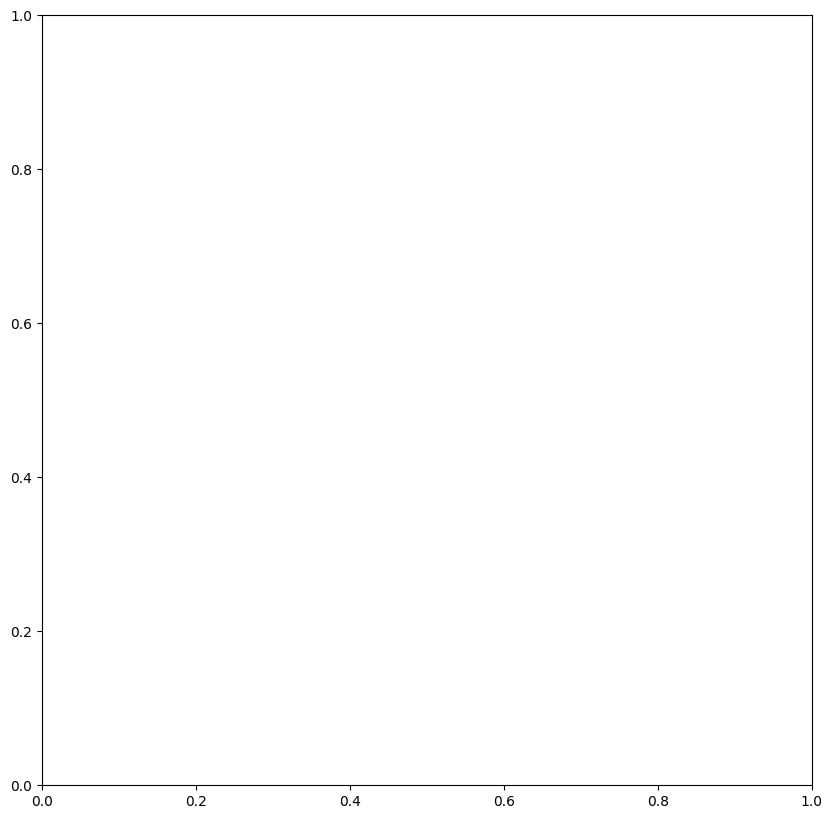

In [28]:
rgb_img = dataset.__getitem__(1)['rgb']
bbox_points = dataset.__getitem__(1)['bbox']
mask_img = dataset.__getitem__(1)['foreground_labels']

# seg = visualize_segmentation(rgb_img, torch_to_numpy(mask_img))
plt.figure(figsize=(10,10))
plt.imshow(torch_to_numpy(rgb_img))
plt.axis('on')
plt.show()
print(type(rgb_img))
print(type(torch_to_numpy(rgb_img)))
# show_boxes_on_image(torch_to_numpy(rgb_img), bbox_points)

In [1]:
from torchvision.utils import draw_bounding_boxes

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """

    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor


def process_rgb( rgb_img):
        """ Process RGB image
                - random color warping
        """
        rgb_img = rgb_img.astype(np.float32)
        rgb_img = standardize_image(rgb_img)

        return rgb_img

scene_dir = "C:/dataset/TOD/training_set/scene_00000/"
# for view_num in range(7):
view_num=0
rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
rgb_img_raw = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB)
rgb_img = process_rgb(rgb_img_raw)
rgb_img = array_to_tensor(rgb_img)
plt.figure(figsize=(10,10))
plt.imshow(rgb_img)
plt.axis('on')
plt.show()


# foreground_labels_filename = scene_dir + f"segmentation_{view_num:05d}.png"
# foreground_labels = imread_indexed(foreground_labels_filename)
# seg = visualize_segmentation(rgb_img_raw, foreground_labels)
# plt.figure(figsize=(10,10))
# plt.imshow(seg)
# plt.axis('on')
# plt.show()

# bbox_filename = scene_dir + f"bbox_{view_num:05d}.txt"
# bbox_points = np.loadtxt(bbox_filename)
# if view_num==1:
#     bbox_points = [bbox_points]
# show_boxes_on_image(rgb_img_raw, bbox_points)

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'cv2' is not defined

In [ ]:
# from tqdm import tqdm
# import os
# import numpy as np
# import torch
# from torchvision.io import read_image

# DATASET_PATH = "C:/dataset/TOD/training_set"
# DATASET_DIR = os.listdir(DATASET_PATH)
# for folder in DATASET_DIR:
#     folder_path = os.path.join(DATASET_PATH, folder)
#     for i in range(1,7):
#         img_path = os.path.join(folder_path, f"rgb_0000{i}.jpeg")
#         mask_path = os.path.join(folder_path, f"segmentation_0000{i}.png")
#         bbox_path = os.path.join(folder_path, f"bbox_0000{i}.txt")
#         img = read_image(img_path)
#         mask = read_image(mask_path)
#         bbox = np.loadtxt(bbox_path)

        

Model

In [1]:
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\divya\.cache\huggingface\hub\models--facebook--sam-vit-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an ad

In [8]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
# Freeze The Encoder and Decoder 
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("mask_decoder"):
    param.requires_grad_(False)

NameError: name 'model' is not defined

# APPROACH 27/06/2024 AFTERNOON